In [1]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy.stats
from tqdm import tqdm

seed = 10000
torch.manual_seed(seed)
np.random.seed(seed)

generate_data = False
load = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
class Net(nn.Module):
    
    def __init__(self, n_input, n_output):
        super(Net, self).__init__()
        
        # encoder
        self.enc1 = nn.Linear(n_input,50)
        self.enc2 = nn.Linear(50,25)
        self.enc3 = nn.Linear(25,10)
        
        # decoder
        self.dec1 = nn.Linear(10, 25)
        self.dec2 = nn.Linear(25, 50)
        self.dec3 = nn.Linear(50, n_output)
        
        #bn
        self.bn_enc1 = nn.BatchNorm1d(50)
        self.bn_enc2 = nn.BatchNorm1d(25)
        self.bn_enc3 = nn.BatchNorm1d(10)
        self.bn_dec1 = nn.BatchNorm1d(25)
        self.bn_dec2 = nn.BatchNorm1d(50)


    def forward(self, x):
        x = self.bn_enc1(torch.relu(self.enc1(x)))
        x = self.bn_enc2(torch.relu(self.enc2(x)))
        x = self.bn_enc3(torch.relu(self.enc3(x)))
        x = self.bn_dec1(torch.relu(self.dec1(x)))
        x = self.bn_dec2(torch.relu(self.dec2(x)))
        x = F.softmax(self.dec3(x), dim=1)
        return x

In [3]:
def num_samples_per_mode(num_modes, total_points):
    """
    Returns the number of points to sample for each number of mode.
    
    Args:
        num_modes: number of different modes in the multimodal distribution
        total_points: total number of points to draw for all modes
        
    Returns:
        array with the number of samples per mode. the elements sum to total_points
    """
    prob_per_mode = np.random.dirichlet(np.ones(num_modes))
    num_samples = []
    
    for i in range(num_modes):
        
        if i == num_modes - 1: # if the last mode:
            num = total_points - sum(num_samples)
        else:
            num = int(prob_per_mode[i] * total_points)
            
        num_samples.append(num)
        
    return np.array(num_samples)

In [4]:
def draw_binned_gaussian(num_data, num_samples, num_bins, num_modes):
    """
    Returns (binned_data, binned_edges)
    binned_data contains the binned training data, has dimensions [num_data, num_bins]
    binned_edges contains the binned edges, has dimensions [num_data, num_bins+1]
    
    Args:
        num_data: number of data points (full batch size)
        num_samples: number of samples/particles to draw
        num_bins: number of bins
        num_modes: number of modes you want in the data. each data
                   point will have a random number of modes from 1 to num_modes
    """
    
    binned_data = np.empty((0, num_bins), float)
    edges = np.empty((0, num_bins+1), float)
    
    for i in tqdm(range(num_data)):
        num_mode = np.random.randint(low=1, high=num_modes)
        num_samples_list = num_samples_per_mode(num_mode, num_samples)
        
        points = np.empty(shape=0)
        
        for n_samples in num_samples_list:
            mean = np.random.uniform(-10,10)
            std = np.random.uniform(1,1.5)
            points_ = np.random.normal(loc=mean, scale=std, size=n_samples)
            points = np.append(points, points_)
            
        ## normalize
        points =  (points - np.mean(points))/np.std(points)
        bins_, edges_ = np.histogram(points, bins=num_bins)
        bins_ = bins_/num_samples
        
        binned_data = np.append(binned_data, [bins_], axis=0)
        edges = np.append(edges, [edges_], axis=0)
        
    return binned_data, edges
        

In [5]:
train_num_data = 50000
test_num_data = 5000
num_samples = 10000
num_bins = 100
num_modes = 10

if generate_data is True:
    train_data, train_edges = draw_binned_gaussian(train_num_data, num_samples, num_bins, num_modes)
    test_data, test_edges = draw_binned_gaussian(test_num_data, num_samples, num_bins, num_modes)
    np.save("train_data.npy", train_data)
    np.save("train_edges.npy", train_edges)
    np.save("test_data.npy", test_data)
    np.save("test_edges.npy", test_edges)
else:
    train_data = np.load("train_data.npy")
    train_edges = np.load("train_edges.npy")
    test_data = np.load("test_data.npy")
    test_edges = np.load("test_edges.npy")

In [6]:
train_data = train_data.astype(np.float32)
train_data = torch.from_numpy(train_data)
train_data = train_data.to(device)

In [7]:
test_data = test_data.astype(np.float32)
test_data = torch.from_numpy(test_data)
test_data = test_data.to(device)

In [8]:
epochs = 30000
net = Net(100,100)
net = net.to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_func = nn.KLDivLoss()
net.train()

Net(
  (enc1): Linear(in_features=100, out_features=50, bias=True)
  (enc2): Linear(in_features=50, out_features=25, bias=True)
  (enc3): Linear(in_features=25, out_features=10, bias=True)
  (dec1): Linear(in_features=10, out_features=25, bias=True)
  (dec2): Linear(in_features=25, out_features=50, bias=True)
  (dec3): Linear(in_features=50, out_features=100, bias=True)
  (bn_enc1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_enc2): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_enc3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_dec1): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_dec2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [9]:
phase_est_data = np.load("train_data.npy")
phase_est_data = phase_est_data.astype(np.float32)
phase_est_data = torch.from_numpy(phase_est_data)
phase_est_data = phase_est_data.to(device)

phase_est_edges = np.load("train_edges.npy")

In [10]:
if load is False:
    for e in range(epochs):
        prediction = net(train_data)
        loss = loss_func(torch.log(prediction), train_data)
        train_loss = loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (e+1)%250 == 0:
            net.eval()
            test_pred = net(test_data)
            loss = loss_func(torch.log(test_pred), test_data)
            test_loss = loss.item()

            phase_est_pred = net(phase_est_data)
            loss = loss_func(torch.log(phase_est_pred), phase_est_data)
            phase_est_loss = loss.item()

            print("Epoch: {:d}, train loss: {:f}, test loss: {:f}, phase est loss: {:f}"
                  .format(e, train_loss, test_loss, phase_est_loss))
            net.train()

    torch.save(net.state_dict(), "net_bn_aft_relu_dropout.model")
else:
    net.load_state_dict(torch.load("net_bn_aft_relu.model"))

net.eval()

Net(
  (enc1): Linear(in_features=100, out_features=50, bias=True)
  (enc2): Linear(in_features=50, out_features=25, bias=True)
  (enc3): Linear(in_features=25, out_features=10, bias=True)
  (dec1): Linear(in_features=10, out_features=25, bias=True)
  (dec2): Linear(in_features=25, out_features=50, bias=True)
  (dec3): Linear(in_features=50, out_features=100, bias=True)
  (bn_enc1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_enc2): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_enc3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_dec1): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_dec2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

IndexError: index 4475 is out of bounds for dimension 0 with size 1

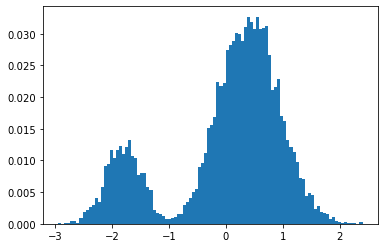

In [16]:
test_pred = net(test_data)
idx_to_plot = np.random.choice(test_num_data, size=100)

for i in idx_to_plot:
    
    test_edges_ = test_edges[i][:-1]
    edge_width = test_edges_[1] - test_edges_[0]

    plt.bar(test_edges_, test_data[i].cpu(), align='edge', width = edge_width)
    plt.bar(test_edges_, test_pred[i].detach().cpu(), align='edge', width = edge_width, alpha=0.7)
    plt.show() 
    

In [ ]:
phase_est_pred = net(phase_est_data)
idx_to_plot = np.random.choice(len(phase_est_data), size=100)

for i in idx_to_plot:
    
    phase_est_edges_ = phase_est_edges[i][:-1]
    edge_width = phase_est_edges_[1] - phase_est_edges_[0]

    plt.bar(phase_est_edges_, phase_est_data[i].cpu(), align='edge', width = edge_width)
    plt.bar(phase_est_edges_, phase_est_pred[i].detach().cpu(), align='edge', width = edge_width, alpha=0.7)
    plt.show() 